In [1]:
cd ..

/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode


In [2]:
pwd


'/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode'

In [3]:
import os, sys
from glob import glob
import math
from pprint import pprint
import torch

import pygarment as pyg
import numpy as np
import matplotlib.pyplot as plt
import json
import svgpathtools
from svgpathtools import Path, Line
from matplotlib.colors import CenteredNorm
import time


def plot_panel_info(
    ax, panel_name, panel_svg_path_dict, stitch_dict,
    N_SAMPLES: int = 100,
):
    path = panel_svg_path_dict[panel_name][0]
    
    # boundary_points = np.array([path.point(t) for t in np.linspace(0, 1, N_SAMPLES)])
    # boundary_points = np.array([boundary_points.real, boundary_points.imag]).T
        
    # ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'b-')
    ax.set_title(panel_name)
    ax.axis('equal')
    ax.grid(True)

    # Create a color map for different edges
    colors = plt.cm.rainbow(np.linspace(0, 1, len(path)))

    for edge_idx, segment in enumerate(path):
        
        segment_points = np.array([
            [segment.point(t).real, segment.point(t).imag]
            for t in np.linspace(0, 1, N_SAMPLES)
        ])
        
        ax.plot(
            segment_points[:, 0],
            segment_points[:, 1] * -1,
            '-', color=colors[edge_idx]
        )
        
        segment_center = segment.point(0.5)
        segment_center = np.array([segment_center.real, segment_center.imag])
    
        has_stitch = False
    
        for stitch_idx, stitch_edges in stitch_dict.items():
            # print(stitch_idx, stitch_edges)
            for edge_info in stitch_edges:
                if edge_info['edge'] == edge_idx and edge_info['panel'] == panel_name:
                    has_stitch = True
                    ax.text(
                        segment_center[0],
                        -segment_center[1],
                        f"{stitch_idx}\n{edge_info['edge']}",
                        ha='center', va='center'
                    )

        if not has_stitch:
            ax.text(
                segment_center[0],
                -segment_center[1],
                f"no stitch,\n{edge_idx}",
                ha='center', va='center'
            )
            
            

def is_point_inside_path(path: Path, point: complex) -> bool:
    """
    Determine if a point is inside the path using ray casting.
    """
    ray_end = point + 1000 + 0j  # Cast ray in positive x direction
    intersections = 0
    
    for segment in path:
        ray = Line(point, ray_end)
        crossings = segment.intersect(ray)
        # crossings returns list of (t1, t2) tuples
        # t1 is parameter for first curve, t2 for second curve
        # We only care about t1 values between 0 and 1
        intersections += sum(1 for t1, t2 in crossings if 0 <= t1 <= 1)
    
    return intersections % 2 == 1

def compute_signed_distance_grid(
    path: svgpathtools.Path,
    n_samples: int = 1000,
    grid_size: int = 200,
    SDF_DOMAIN_SIZE: float = 2,
    ZOOM_OUT_FACTOR: float = 1.2,
    K_NEIGHBORS: int = 5
) -> torch.Tensor:
    """
    Compute signed distance field for an SVG path.
    args :
        path : svgpathtools.Path
            unnormalized closed path
        n_samples : int, number of samples along the path

        img_size : int, size of the grid
    """
    edge_lengths = [segment.length() for segment in path]
    total_length = sum(edge_lengths)
    
    # Distribute points proportionally to edge lengths
    points_per_edge = [
        max(int(n_samples * length / total_length), 10)  # Ensure minimum 10 points per edge
        for length in edge_lengths
    ]
    
    edge_points = []
    for edge_idx, segment in enumerate(path):
        t_vals = torch.linspace(0, 1, points_per_edge[edge_idx])
        edge_samples = torch.tensor([
            [segment.point(t.item()).real, segment.point(t.item()).imag]
            for t in t_vals
        ])
        edge_points.append(edge_samples)
    
    # Combine all points and create edge index mapping
    boundary_points = torch.cat(edge_points, dim=0)
    edge_indices = torch.cat([
        torch.full((points_per_edge[i],), i, dtype=torch.int64)
        for i in range(len(path))
    ])
    
    # get bounding box of the path
    xmin, xmax, ymin, ymax = path.bbox()
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    x_scale = xmax - xmin
    y_scale = ymax - ymin
    
    scale_factor = max(x_scale, y_scale) * ZOOM_OUT_FACTOR / SDF_DOMAIN_SIZE
    
    boundary_points_normalized = (
        boundary_points - torch.tensor([x_center, y_center])
    ) / scale_factor
     
    # get grid of evaluation points
    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, grid_size),
        torch.linspace(-1, 1, grid_size)
    ), dim=-1).reshape(-1, 2)[:, [1, 0]].float()
    
    # Compute unsigned distances
    coords_expanded = coords.unsqueeze(1)
    points_expanded = boundary_points_normalized.unsqueeze(0)
    distances = torch.norm(coords_expanded - points_expanded, dim=2)
    unsigned_distances, min_indices = torch.min(distances, dim=1)
    
    k_distances, k_indices = torch.topk(
        distances, k=K_NEIGHBORS, dim=1, largest=False
    )
    k_edge_indices = edge_indices[k_indices]
    weights = 1.0 / (k_distances + 1e-6)

    n_edges = len(path)

    one_hot = torch.zeros(
        k_edge_indices.shape[0], K_NEIGHBORS, n_edges
    )
    one_hot.scatter_(2, k_edge_indices.unsqueeze(-1), 1)
    
    # Apply weights to votes
    weighted_votes = one_hot * weights.unsqueeze(-1)
    
    # Sum votes for each edge
    edge_votes = weighted_votes.sum(dim=1)
    
    # Get edge with maximum votes
    closest_edge_indices = edge_votes.argmax(dim=1)
    
    # closest_edge_indices = edge_indices[min_indices]
    
    # For sign computation, transform coords back to original space
    signs = torch.tensor([
        -1 if is_point_inside_path(
            path, complex(x.item(), y.item())
        ) else 1
        for x, y in coords * scale_factor + torch.tensor([x_center, y_center])
    ])
    signed_distances = unsigned_distances * signs
    
    return (
        signed_distances.reshape(grid_size, grid_size),
        closest_edge_indices.reshape(grid_size, grid_size),
        scale_factor
    )



# PATTERN_PATH = "/Users/hjp/HJP/KUAICV/VTO/DATASET/GarmentCodeData/GarmentCodeData_v2/garments_5000_2/default_body/rand_0B4PVW9R6O/rand_0B4PVW9R6O_specification.json"
# DATAPOINT_PATH = "/Users/hjp/HJP/KUAICV/VTO/GarmentCode/assets/rand_0J0BGQ4VMZ"
# GARMENT_ID = os.path.basename(DATAPOINT_PATH)
# SPEC_FILE_PATH = os.path.join(DATAPOINT_PATH, f"{GARMENT_ID}_specification.json")


In [4]:
# pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

# panel_svg_path_dict = {
#     panel_name : pattern._draw_a_panel(
#         panel_name, apply_transform=False, fill=True
#     )
#     for panel_name in pattern.panel_order()
# }
# stitch_dict = {
#     i : v for i, v in enumerate(pattern.pattern['stitches'])
# }

In [5]:
# GRID_SIZE = 400
# N_SAMPLES = 10000

# signed_distance_data_dict = {
#     "grid_size" : GRID_SIZE,
#     "n_samples" : N_SAMPLES,
#     "panel_name_list" : pattern.panel_order(),
#     "scale_factor_list" : [],
# }

# signed_distance_grid_list = []
# edge_indices_grid_list = []

# for panel_name in pattern.panel_order():
#     panel_svg_path = panel_svg_path_dict[panel_name][0]
#     sd_grid, edge_indices_grid, scale_factor = compute_signed_distance_grid(
#         panel_svg_path,
#         n_samples=N_SAMPLES,
#         grid_size=GRID_SIZE
#     )
#     signed_distance_data_dict["scale_factor_list"].append(scale_factor)
#     signed_distance_grid_list.append(sd_grid)
#     edge_indices_grid_list.append(edge_indices_grid)
    
# signed_distance_grid_array = np.array(signed_distance_grid_list)
# edge_indices_grid_array = np.array(edge_indices_grid_list)
    
# SIGNED_DISTANCE_METADATA_PATH = os.path.join(
#     DATAPOINT_PATH, "signed_distance_metadata.json"
# )
# with open(SIGNED_DISTANCE_METADATA_PATH, "w") as f:
#     json.dump(signed_distance_data_dict, f)
    
# SIGNED_DISTANCE_GRID_PATH = os.path.join(
#     DATAPOINT_PATH, "signed_distance_grid.npy"
# )
# np.save(SIGNED_DISTANCE_GRID_PATH, signed_distance_grid_array)

# SIGNED_EDGE_INDICES_GRID_PATH = os.path.join(
#     DATAPOINT_PATH, "closest_edge_indices_grid.npy"
# )
# np.save(SIGNED_EDGE_INDICES_GRID_PATH, edge_indices_grid_array)


# THRESHOLD = 0.005

# for sd_grid, edge_indices_grid in zip(signed_distance_grid_list, edge_indices_grid_list):

#     print(sd_grid.dtype, edge_indices_grid.dtype)
    
#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(sd_grid.cpu().numpy(), cmap='RdBu', norm=CenteredNorm())
#     plt.colorbar(label='Signed Distance')
#     plt.axis('equal')
#     plt.title('Signed Distance')

#     grid_np = sd_grid.cpu().numpy()
#     boundary_mask = np.logical_and(grid_np < THRESHOLD, grid_np > -THRESHOLD)
#     boundary_y, boundary_x = np.where(boundary_mask)
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(edge_indices_grid.cpu().numpy(), cmap='Set3')
#     plt.colorbar(label='Edge Index')
    
#     plt.scatter(boundary_x, boundary_y, c='r', s=0.01)
#     plt.axis('equal')
#     plt.title(np.unique(edge_indices_grid.cpu().numpy()))
#     plt.show()

In [6]:
def make_signed_distance_data(
    DATAPOINT_PATH: str,
    GRID_SIZE: int = 400,
    N_SAMPLES: int = 10000,
    SDF_DOMAIN_SIZE: float = 2,
    ZOOM_OUT_FACTOR: float = 1.1,
    K_NEIGHBORS: int = 5,
) :
    GARMENT_ID = os.path.basename(DATAPOINT_PATH)
    SPEC_FILE_PATH = os.path.join(DATAPOINT_PATH, f"{GARMENT_ID}_specification.json")
    pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)
    
    panel_name_list = pattern.panel_order()
    
    panel_svg_path_dict = {
        panel_name : pattern._draw_a_panel(
            panel_name, apply_transform=False, fill=True
        )
        for panel_name in panel_name_list
    }
    stitch_dict = {
        i : v for i, v in enumerate(pattern.pattern['stitches'])
    }
    
    
    signed_distance_data_dict = {
        "grid_size" : GRID_SIZE,
        "n_samples" : N_SAMPLES,
        "panel_name_list" : panel_name_list,
        "sdf_domain_size" : SDF_DOMAIN_SIZE,
        "zoom_out_factor" : ZOOM_OUT_FACTOR,
        "k_neighbors" : K_NEIGHBORS,
        "scale_factor_list" : [],
    }
    
    signed_distance_grid_list = []
    edge_indices_grid_list = []
    
    for panel_name in panel_name_list:
        panel_svg_path = panel_svg_path_dict[panel_name][0]
        sd_grid, edge_indices_grid, scale_factor = compute_signed_distance_grid(
            panel_svg_path,
            n_samples=N_SAMPLES,
            grid_size=GRID_SIZE,
            ZOOM_OUT_FACTOR=ZOOM_OUT_FACTOR,
            K_NEIGHBORS=K_NEIGHBORS
        )
        signed_distance_data_dict["scale_factor_list"].append(scale_factor)
        signed_distance_grid_list.append(sd_grid)
        edge_indices_grid_list.append(edge_indices_grid)
        
    signed_distance_grid_array = np.array(signed_distance_grid_list)
    edge_indices_grid_array = np.array(edge_indices_grid_list)
    

    SIGNED_DISTANCE_METADATA_PATH = os.path.join(
        DATAPOINT_PATH, "signed_distance_metadata.json"
    )
    with open(SIGNED_DISTANCE_METADATA_PATH, "w") as f:
        json.dump(signed_distance_data_dict, f, indent=4)
        
    SIGNED_DISTANCE_GRID_PATH = os.path.join(
        DATAPOINT_PATH, "signed_distance_grid.npy"
    )
    np.save(SIGNED_DISTANCE_GRID_PATH, signed_distance_grid_array)

    CLOSEST_EDGE_INDICES_GRID_PATH = os.path.join(
        DATAPOINT_PATH, "closest_edge_indices_grid.npy"
    )
    np.save(CLOSEST_EDGE_INDICES_GRID_PATH, edge_indices_grid_array)

In [28]:
# make_signed_distance_data(
#     "/Users/hjp/HJP/KUAICV/VTO/GarmentCode/assets/rand_0FLZP5KRNR",
#     GRID_SIZE=400,
#     N_SAMPLES=10000,
#     ZOOM_OUT_FACTOR=1.1,
#     K_NEIGHBORS=5
# )

## Evaluate Preprocesed Data

In [6]:
# cd ..

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import json

import pygarment
import pygarment as pyg

import svgpathtools
from svgpathtools import Path, Line


def plot_panel_info(
    ax, panel_name, panel_svg_path_dict, stitch_dict,
    N_SAMPLES: int = 100,
):
    path = panel_svg_path_dict[panel_name][0]
    
    # boundary_points = np.array([path.point(t) for t in np.linspace(0, 1, N_SAMPLES)])
    # boundary_points = np.array([boundary_points.real, boundary_points.imag]).T
        
    # ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'b-')
    ax.set_title(panel_name)
    ax.axis('equal')
    ax.grid(True)

    # Create a color map for different edges
    colors = plt.cm.rainbow(np.linspace(0, 1, len(path)))

    for edge_idx, segment in enumerate(path):
        
        segment_points = np.array([
            [segment.point(t).real, segment.point(t).imag]
            for t in np.linspace(0, 1, N_SAMPLES)
        ])
        
        ax.plot(
            segment_points[:, 0],
            segment_points[:, 1] * -1,
            '-', color=colors[edge_idx]
        )
        
        segment_center = segment.point(0.5)
        segment_center = np.array([segment_center.real, segment_center.imag])
    
        has_stitch = False
    
        for stitch_idx, stitch_edges in stitch_dict.items():
            # print(stitch_idx, stitch_edges)
            for edge_info in stitch_edges:
                if edge_info['edge'] == edge_idx and edge_info['panel'] == panel_name:
                    has_stitch = True
                    ax.text(
                        segment_center[0],
                        -segment_center[1],
                        f"{stitch_idx}\n{edge_info['edge']}",
                        ha='center', va='center'
                    )

        if not has_stitch:
            ax.text(
                segment_center[0],
                -segment_center[1],
                f"no stitch,\n{edge_idx}",
                ha='center', va='center'
            )
            
            

DATA_POINT = "/Users/hjp/HJP/KUAICV/VTO/GarmentCode/assets/rand_0FLZP5KRNR"
DATA_POINT = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0A36YXPNV0"

GARMENT_ID = os.path.basename(DATA_POINT)
SPEC_FILE_PATH = os.path.join(DATA_POINT, f"{GARMENT_ID}_specification.json")
pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)


panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

SIGNED_DISTANCE_METADATA_PATH = os.path.join(
    DATA_POINT, "signed_distance_metadata.json"
)
with open(SIGNED_DISTANCE_METADATA_PATH, "r") as f:
    signed_distance_data_dict = json.load(f)
    
SIGNED_DISTANCE_GRID_PATH = os.path.join(
    DATA_POINT, "signed_distance_grid.npy"
)
signed_distance_grid_array = np.load(SIGNED_DISTANCE_GRID_PATH)

CLOSEST_EDGE_INDICES_GRID_PATH = os.path.join(
    DATA_POINT, "closest_edge_indices_grid.npy"
)
edge_indices_grid_array = np.load(CLOSEST_EDGE_INDICES_GRID_PATH)


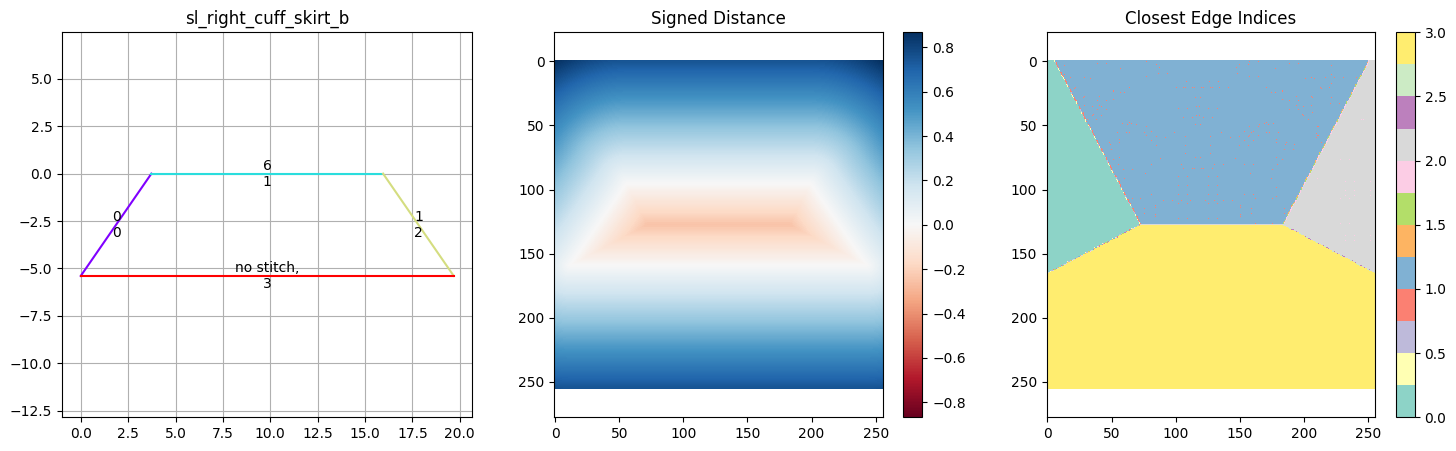

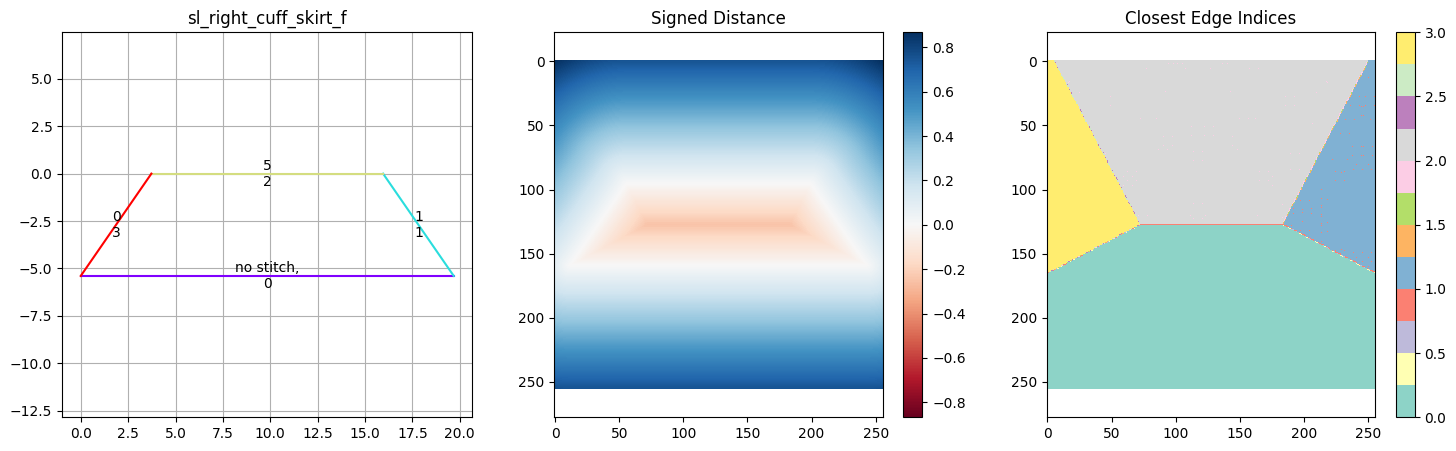

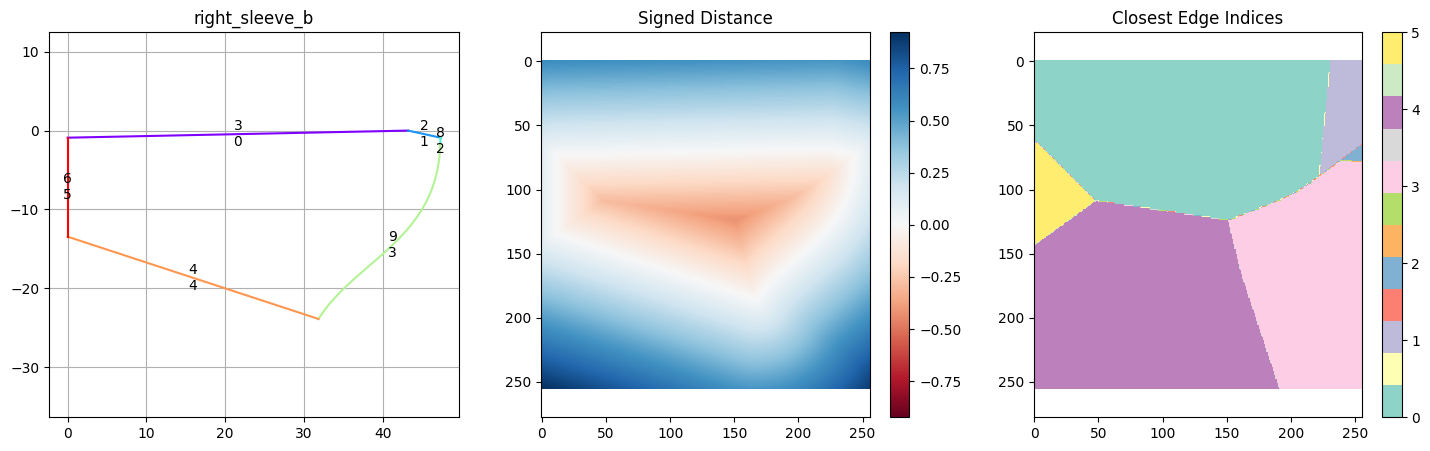

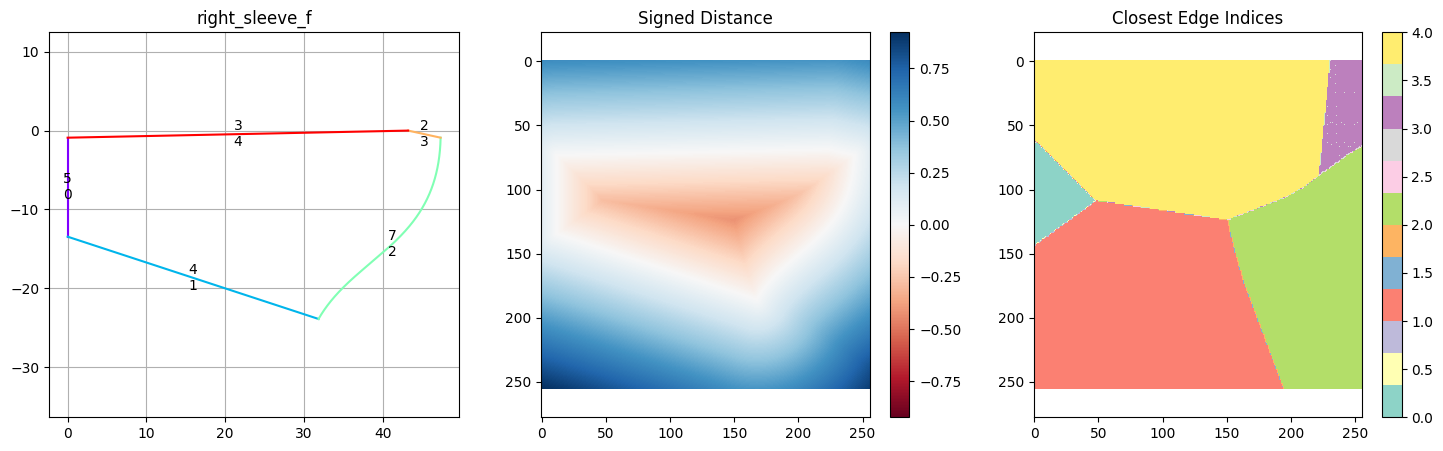

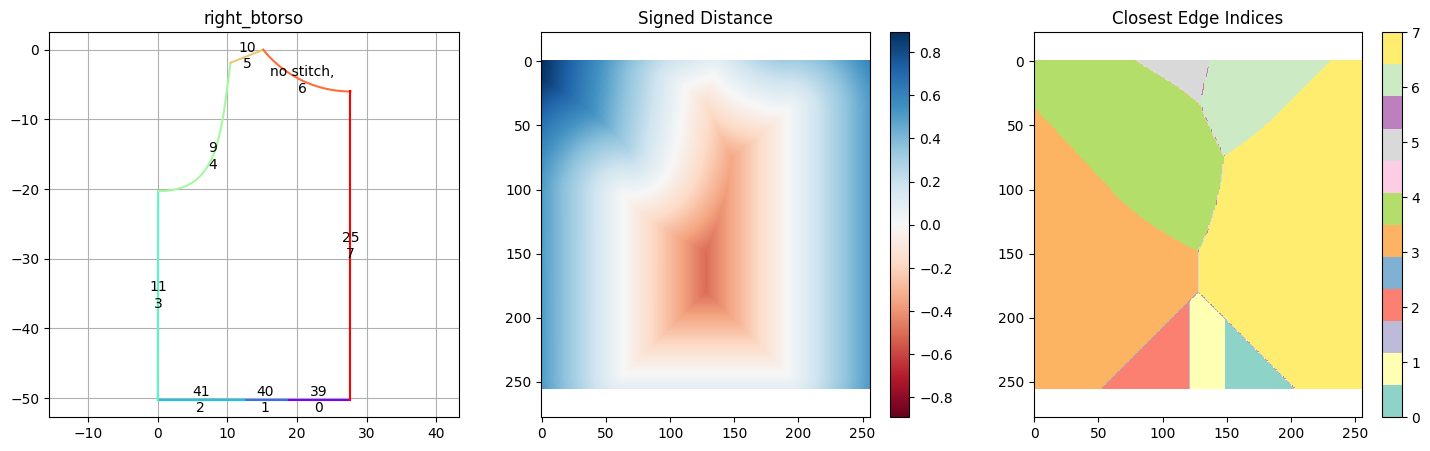

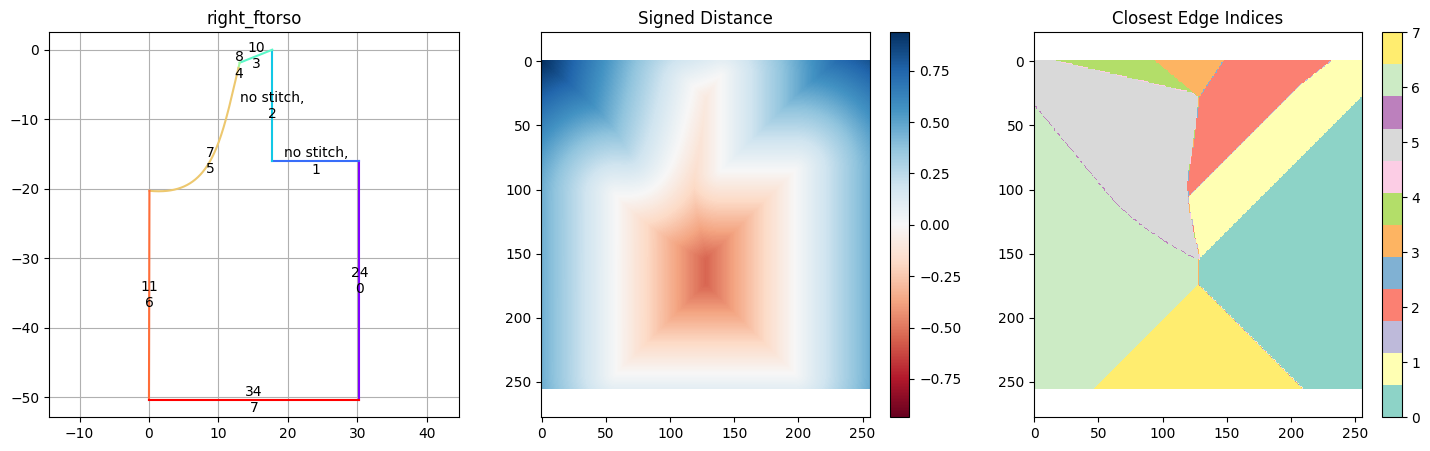

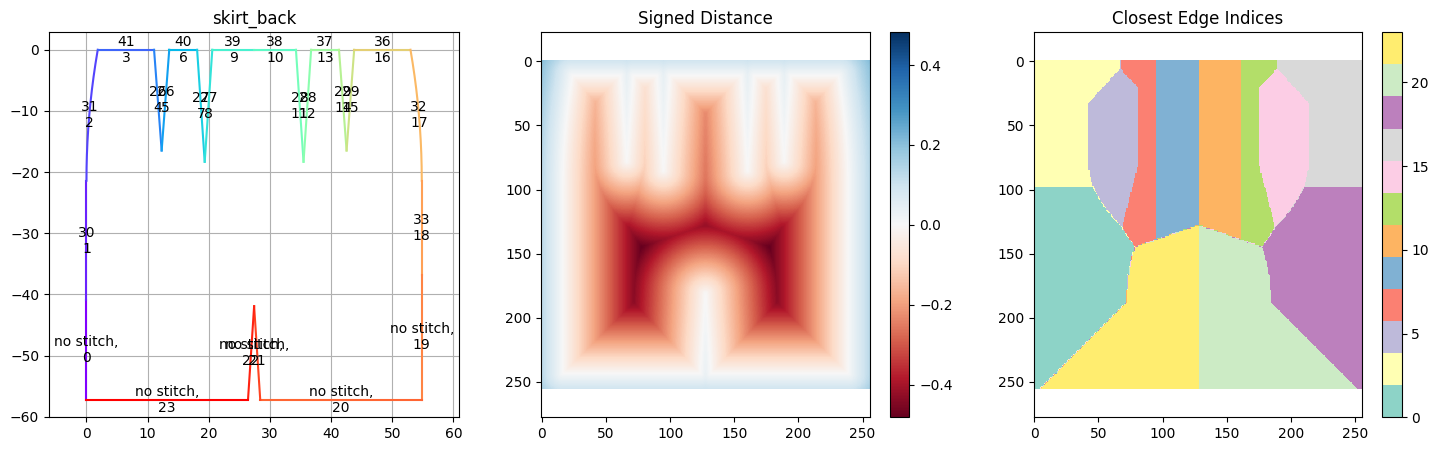

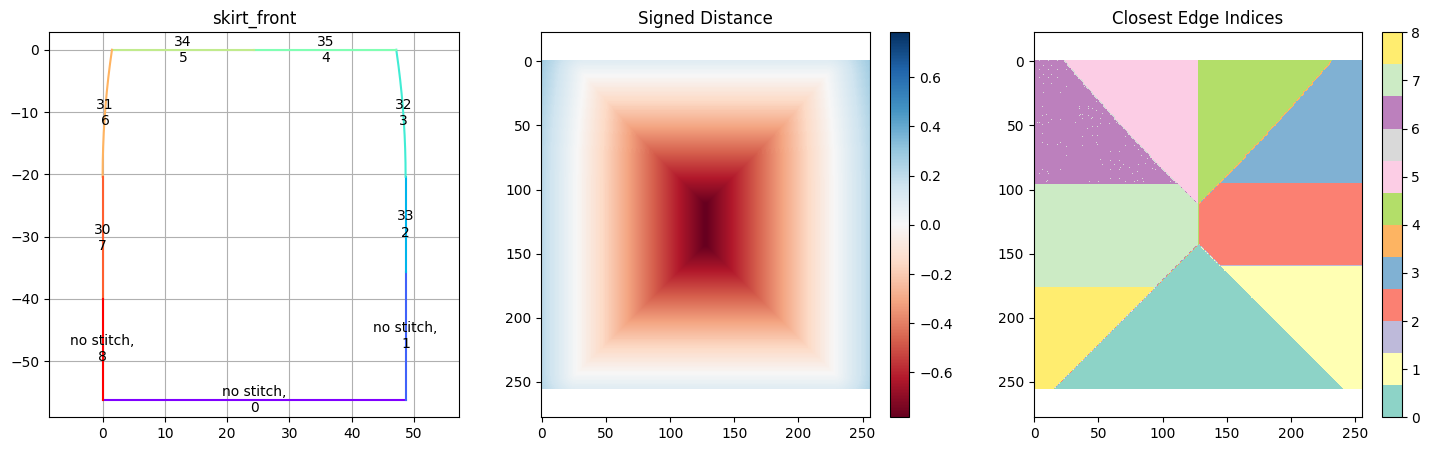

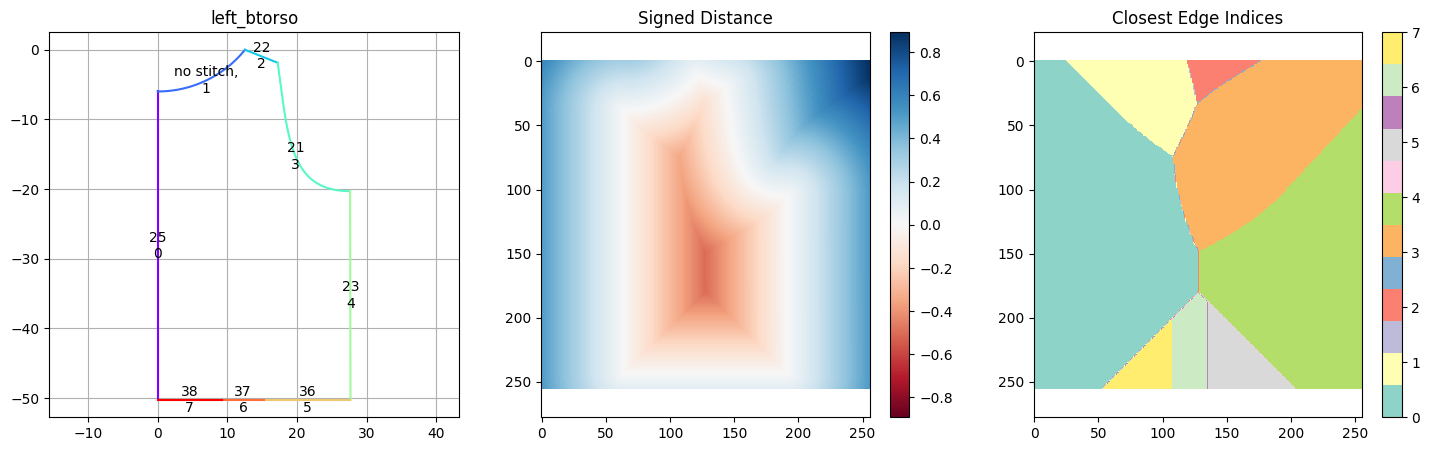

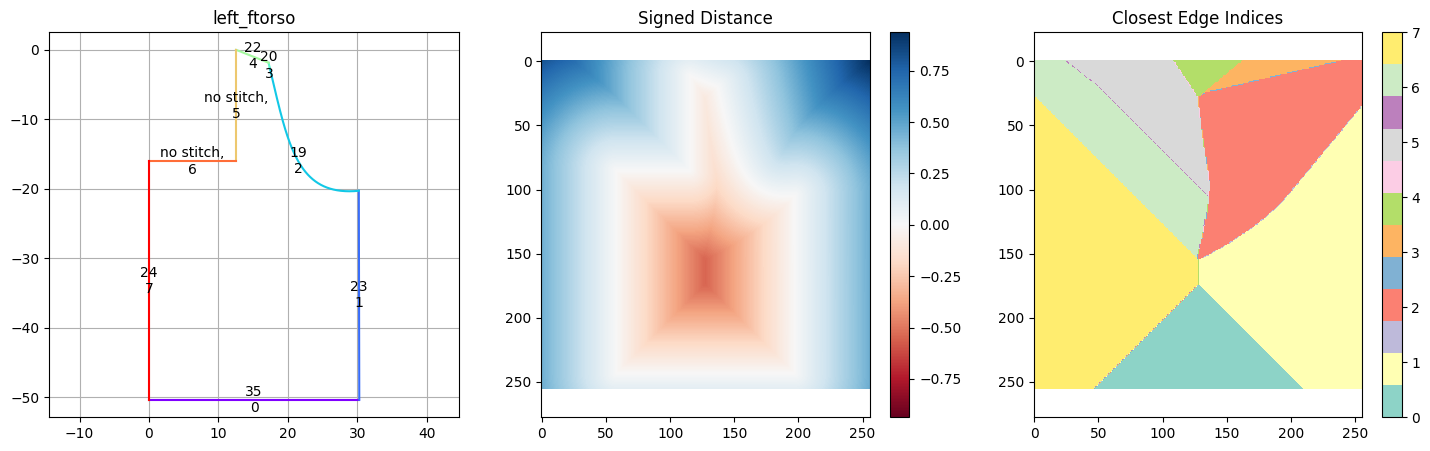

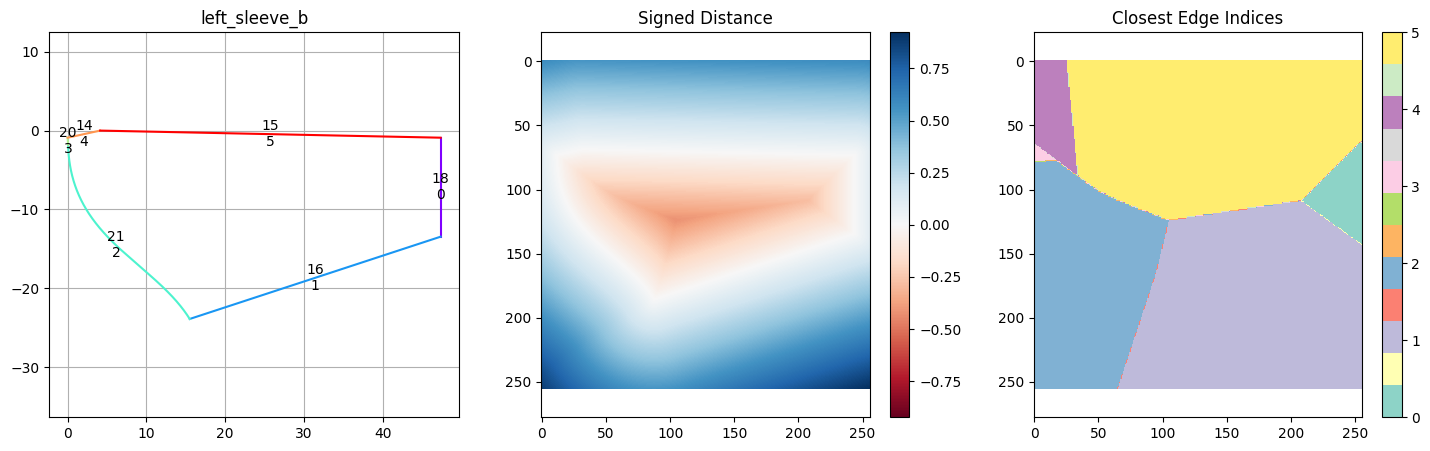

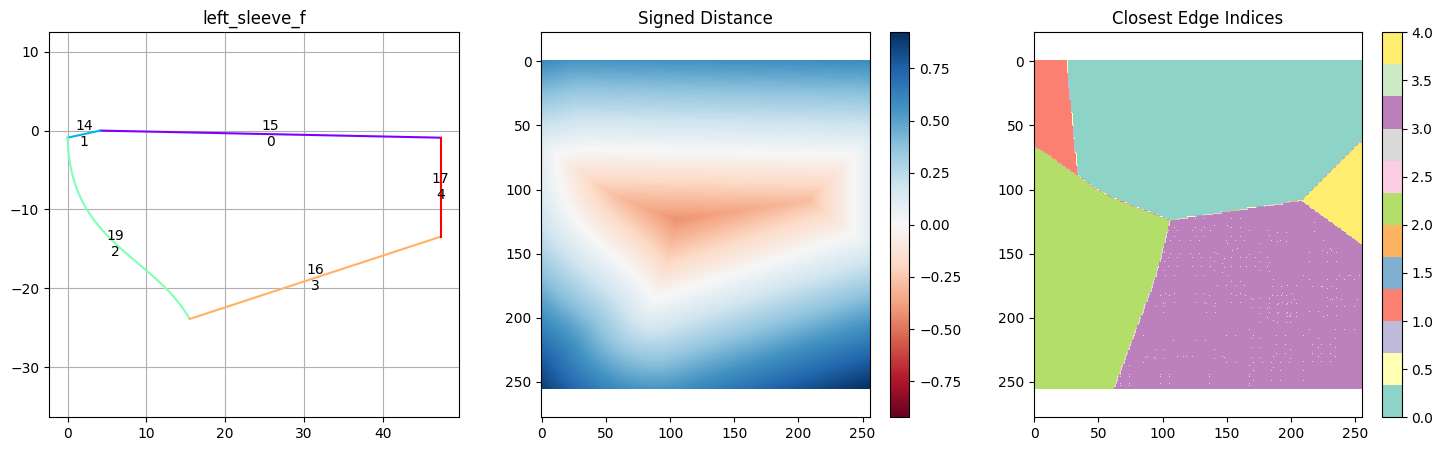

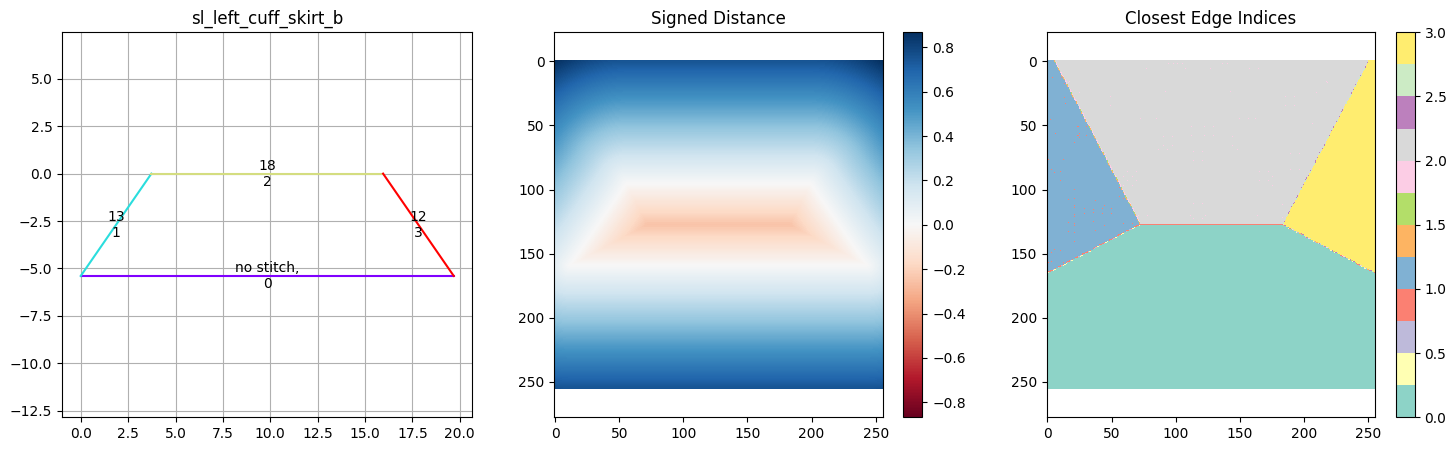

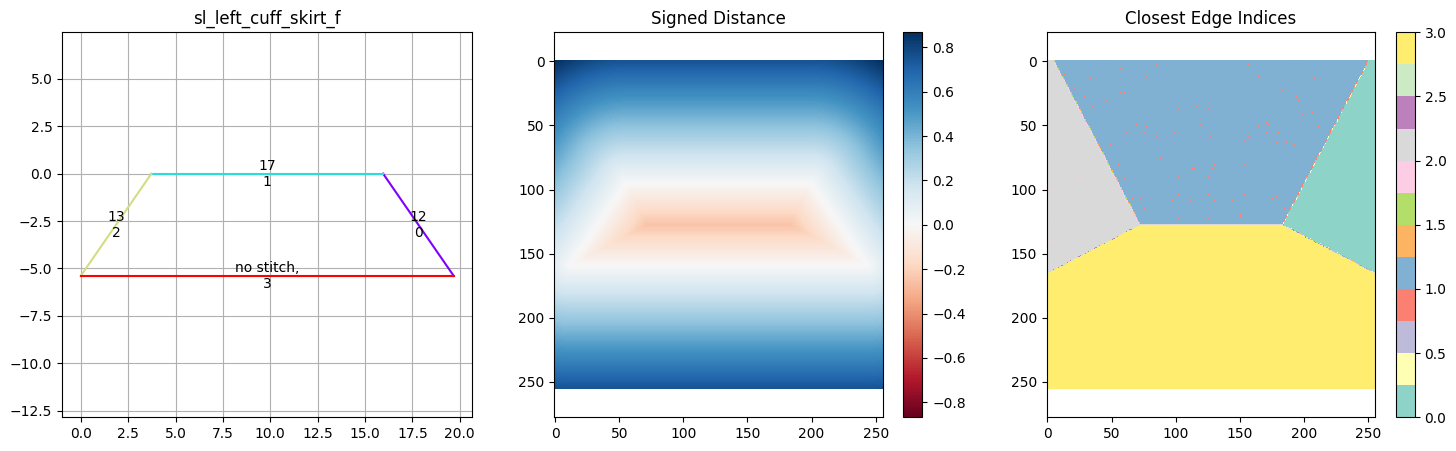

In [6]:
for idx, panel_name in enumerate(
    signed_distance_data_dict  ["panel_name_list"]
):
    sd_grid = signed_distance_grid_array[idx]
    edge_indices_grid = edge_indices_grid_array[idx]
    scale_factor = signed_distance_data_dict["scale_factor_list"][idx]

    SDF_DOMAIN_SIZE = signed_distance_data_dict["sdf_domain_size"]
    ZOOM_OUT_FACTOR = signed_distance_data_dict["zoom_out_factor"]
    K_NEIGHBORS = signed_distance_data_dict["k_neighbors"]
    
    
    plt.figure(figsize=(18, 5))
    ax = plt.subplot(1, 3, 1)
    
    plot_panel_info(
        ax, panel_name, panel_svg_path_dict, stitch_dict,
        N_SAMPLES=1000
    )
    
    plt.subplot(1, 3, 2)
    plt.imshow(sd_grid, cmap='RdBu', norm=CenteredNorm())
    plt.axis('equal')
    plt.title('Signed Distance')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(edge_indices_grid, cmap='Set3')
    plt.axis('equal')
    plt.title('Closest Edge Indices')
    plt.colorbar()
    
    plt.show()


In [7]:
from multiprocessing import Pool
from tqdm import tqdm
import traceback

def process_single_datapoint(args):
    """
    Wrapper function to handle a single datapoint processing with error handling
    """
    datapoint_path, params = args
    try:
        make_signed_distance_data(
            DATAPOINT_PATH=datapoint_path,
            **params
        )
        return (datapoint_path, True, None)
    except Exception as e:
        return (datapoint_path, False, str(e))

def make_signed_distance_data_parallel(
    datapoint_path_list: list,
    n_processes: int = 60,
    **kwargs
):
    """
    Process multiple datapoints in parallel
    
    Args:
        datapoint_path_list: List of paths to process
        n_processes: Number of parallel processes to use
        **kwargs: Parameters to pass to make_signed_distance_data
    """
    # Create argument list for each process
    process_args = [(path, kwargs) for path in datapoint_path_list]
    
    # Create process pool and run processing
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_single_datapoint, process_args),
            total=len(datapoint_path_list)
        ))
    
    # Process results
    successful = []
    failed = []
    
    for path, success, error in results:
        if success:
            successful.append(path)
        else:
            failed.append((path, error))
    
    # Print summary
    print(f"\nProcessing complete!")
    print(f"Successful: {len(successful)}/{len(datapoint_path_list)}")
    print(f"Failed: {len(failed)}/{len(datapoint_path_list)}")
    
    if failed:
        print("\nFailed datapoints:")
        for path, error in failed:
            print(f"- {path}")
            print(f"  Error: {error}")
    
    return successful, failed

# Example usage:
if __name__ == "__main__":
    # Define your parameters
    params = {
        "GRID_SIZE": 400,
        "N_SAMPLES": 10000,
        "ZOOM_OUT_FACTOR": 1.1,
        "K_NEIGHBORS": 5,
        "n_processes": 20  # Adjust based on your CPU cores
    }
        
    datapoint_paths = sorted(list(filter(
        lambda x: (
            os.path.isdir(x)
        ) and (
            "rand" in os.path.basename(x)
        ) and (
            f"{os.path.basename(x)}_specification.json" in os.listdir(x)
        ),
        glob("/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/*/default_body/*")
    )))
    
    # Run parallel processing
    successful, failed = make_signed_distance_data_parallel(
        datapoint_paths,
        **params
    )